# COMPONENT TRENDS

## Import Packages

In [108]:
import os
os.getcwd()
import xarray as xr
import pandas as pd
import numpy as np
import glob
import os
import logging
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy.stats import ttest_ind
import calendar
from scipy.stats import ks_2samp
from scipy.stats import chi2_contingency
import scipy.stats as stats
from scipy.stats import mannwhitneyu
import cartopy.mpl.ticker as cticker
from statsmodels.stats.proportion import proportions_ztest
from matplotlib.colors import BoundaryNorm, ListedColormap

## Load Data

### Drought Factor (DF)

In [3]:
# DF: 2005-2024
df_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/df_new.nc') # import data
df_var_new["df"] = df_var_new["__xarray_dataarray_variable__"] 
df_new = df_var_new["df"] #rename 'kbdi' column to make it a variable (datarray)

# DF: 1979-1998
df_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/df_old.nc')
df_var_old["df"] = df_var_old["__xarray_dataarray_variable__"]
df_old = df_var_old["df"]

### FFDI

In [4]:
# FFDI: 2005-2024
ffdi_nc = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI.nc')
ffdi_nc["ffdi"] = ffdi_nc["__xarray_dataarray_variable__"]
ffdi_var = ffdi_nc["ffdi"]  

# FFDI: 1979-1998:
ffdi_nc_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI_old.nc')
ffdi_nc_old["ffdi"] = ffdi_nc_old["__xarray_dataarray_variable__"]
ffdi_var_old = ffdi_nc_old["ffdi"]  # select the variable as a DataArray

# check values are reasonable
# ffdi_point_old = ffdi_var_old.sel(time="1989-06-05")
# ffdi_point_old.plot(x="lon", y="lat", cmap="Reds") # checking single point mapping

### Temperature

In [5]:
# KBDI: 2005-2024
temp_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/temp_new.nc')
temp_new = temp_var_new["tasmax"]

# KBDI: 1979-1998
temp_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/temp_old.nc')
temp_old = temp_var_old["tasmax"]

### Relative Humidity(RH)

In [6]:
# KBDI: 2005-2024
rh_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/rh_new.nc')
rh_new = rh_var_new["hurs"]

# KBDI: 1979-1998
rh_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/rh_old.nc')
rh_old = rh_var_old["hurs"]

### Windspeed

In [7]:
# ws: 2005-2024
wind_var_new = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/windspeed_new.nc')
wind_var_new["wind"] = wind_var_new["__xarray_dataarray_variable__"]
wind_new = wind_var_new["wind"]

# ws: 1979-1998
wind_var_old = xr.open_dataset('/g/data/ng72/mf9479/k10_transfer/Thesis/windspeed_old.nc')
wind_var_old["wind"] = wind_var_old["__xarray_dataarray_variable__"]
wind_old = wind_var_old["wind"]

# ----------------------------------------------------------------------

# Monthly Averages (Timeseries)

### WINDSPEED

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


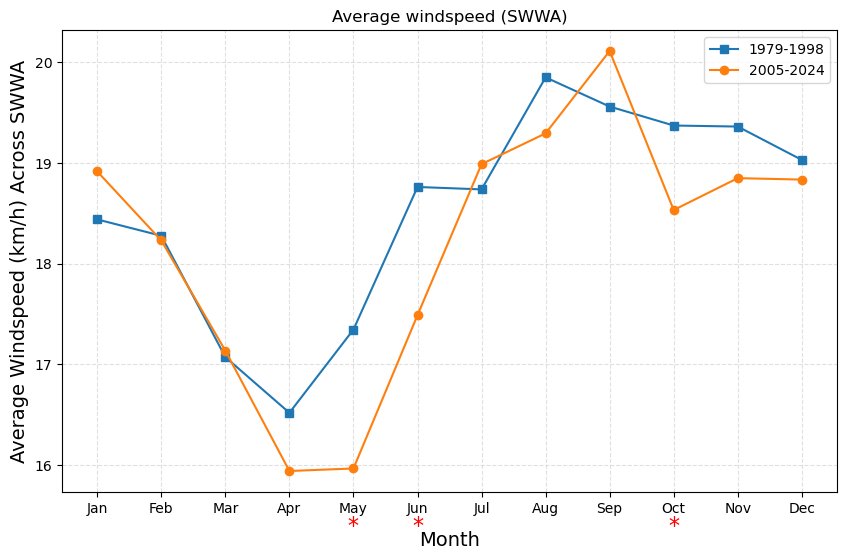

In [23]:
# spatial & monthly avg
wind_avg_new = wind_new.mean(dim=("lat", "lon"))
wind_avg_month_new = wind_avg_new.groupby("time.month").mean("time")
wind_avg_old = wind_old.mean(dim=("lat", "lon"))
wind_avg_month_old = wind_avg_old.groupby("time.month").mean("time")

# Calc stat signficiance (Mann-Whitney U Test)
p_values = []
for m in range(1, 13):
    new_vals = wind_new.sel(time=wind_new['time.month'] == m).mean(dim=("lat", "lon")).values # select month
    old_vals = wind_old.sel(time=wind_old['time.month'] == m).mean(dim=("lat", "lon")).values
    new_vals = new_vals[~np.isnan(new_vals)]
    old_vals = old_vals[~np.isnan(old_vals)]
    stat, p = stats.mannwhitneyu(old_vals, new_vals, alternative='two-sided') # apply stat test
    p_values.append(p)

# figure set-up
plt.figure(figsize=(10,6))
wind_avg_month_old.plot(marker="s", label = "1979-1998")
wind_avg_month_new.plot(marker="o", label = "2005-2024")
plt.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.7) # grid lines

# replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in wind_avg_month_old["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in wind_avg_month_new["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+0)%12+1] for i in range(12)])

# add asterisks for stat sig months
ymin, ymax = plt.ylim()
asterisk_y = ymin - (ymax - ymin) * 0.05  # place slightly below the axis, adjust if needed
for i, p in enumerate(p_values):
    if p < 0.05:
        plt.text(i+1, asterisk_y, '*', ha='center', va='top', fontsize=16, color='red')

# produce figure
plt.title("Average windspeed (SWWA)")
plt.xlabel("Month", fontsize = 14, labelpad = 11) # labelpad lowers title
plt.ylabel("Average Windspeed (km/h) Across SWWA", fontsize = 14)
plt.legend()

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/windspeed_timeseries.png", dpi=600)
plt.show()

### RH

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


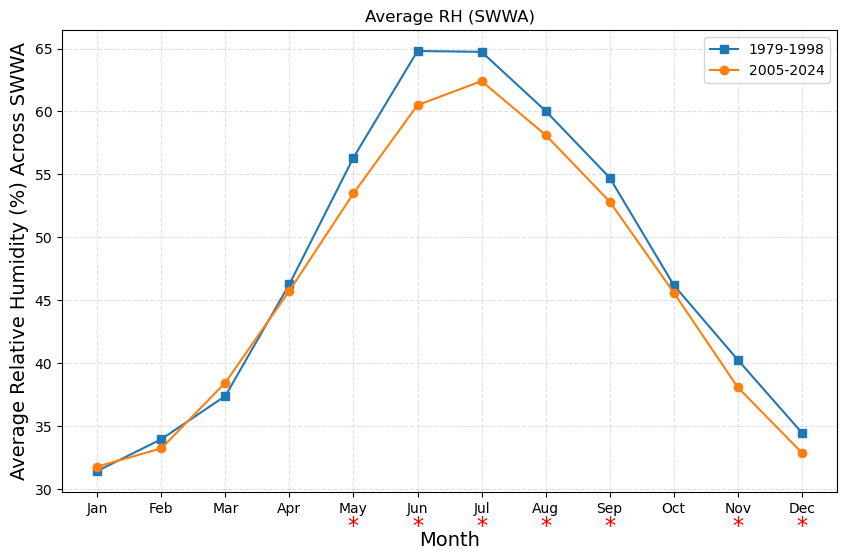

In [24]:
# spatial & monthly avg
rh_avg_new = rh_new.mean(dim=("lat", "lon"))
rh_avg_month_new = rh_avg_new.groupby("time.month").mean("time")
rh_avg_old = rh_old.mean(dim=("lat", "lon"))
rh_avg_month_old = rh_avg_old.groupby("time.month").mean("time")

# Calc stat signficiance (Mann-Whitney U Test)
p_values = []
for m in range(1, 13):
    new_vals = rh_new.sel(time=rh_new['time.month'] == m).mean(dim=("lat", "lon")).values # select month
    old_vals = rh_old.sel(time=rh_old['time.month'] == m).mean(dim=("lat", "lon")).values
    new_vals = new_vals[~np.isnan(new_vals)]
    old_vals = old_vals[~np.isnan(old_vals)]
    stat, p = stats.mannwhitneyu(old_vals, new_vals, alternative='two-sided') # apply stat test
    p_values.append(p)

# figure set-up
plt.figure(figsize=(10,6))
rh_avg_month_old.plot(marker="s", label = "1979-1998")
rh_avg_month_new.plot(marker="o", label = "2005-2024")
plt.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.7) # grid lines

# replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in rh_avg_month_old["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in rh_avg_month_new["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+0)%12+1] for i in range(12)])

# add asterisks for stat sig months
ymin, ymax = plt.ylim()
asterisk_y = ymin - (ymax - ymin) * 0.05  # place slightly below the axis, adjust if needed
for i, p in enumerate(p_values):
    if p < 0.05:
        plt.text(i+1, asterisk_y, '*', ha='center', va='top', fontsize=16, color='red')

# produce figure
plt.title("Average RH (SWWA)")
plt.xlabel("Month", fontsize = 14, labelpad = 11) # labelpad lowers title
plt.ylabel("Average Relative Humidity (%) Across SWWA", fontsize = 14)
plt.legend()

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/rh_timeseries.png", dpi=600)
plt.show()

In [26]:
# finding largest % decrease
# (new-old) / old x 100
percent_change = ((rh_avg_month_new - rh_avg_month_old) / rh_avg_month_old) * 100

# identify month with largest
min_change = percent_change.min().item()  # most negative value
min_month_num = percent_change['month'][percent_change.argmin().item()].item()
min_month_name = calendar.month_abbr[min_month_num]

print(f"Largest % decrease: {min_change:.2f}% in {min_month_name}")

Largest % decrease: -6.64% in Jun


### Temp

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


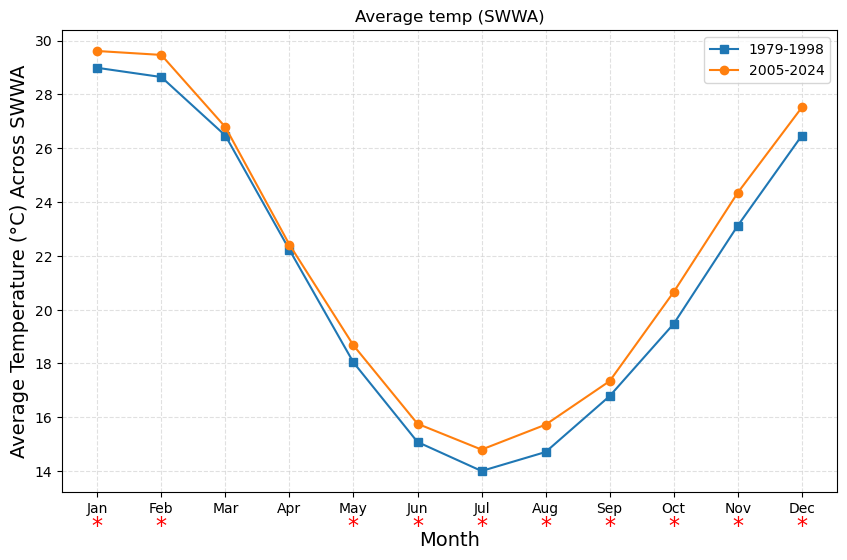

In [27]:
# spatial & monthly avg
temp_avg_new = temp_new.mean(dim=("lat", "lon"))
temp_avg_month_new = temp_avg_new.groupby("time.month").mean("time")
temp_avg_old = temp_old.mean(dim=("lat", "lon"))
temp_avg_month_old = temp_avg_old.groupby("time.month").mean("time")

# Calc stat signficiance (Mann-Whitney U Test)
p_values = []
for m in range(1, 13):
    new_vals = temp_new.sel(time=temp_new['time.month'] == m).mean(dim=("lat", "lon")).values # select month
    old_vals = temp_old.sel(time=temp_old['time.month'] == m).mean(dim=("lat", "lon")).values
    new_vals = new_vals[~np.isnan(new_vals)]
    old_vals = old_vals[~np.isnan(old_vals)]
    stat, p = stats.mannwhitneyu(old_vals, new_vals, alternative='two-sided') # apply stat test
    p_values.append(p)

# figure set-up
plt.figure(figsize=(10,6))
temp_avg_month_old.plot(marker="s", label = "1979-1998")
temp_avg_month_new.plot(marker="o", label = "2005-2024")
plt.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.7) # grid lines

# replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in temp_avg_month_old["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in temp_avg_month_new["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+0)%12+1] for i in range(12)])

# add asterisks for stat sig months
ymin, ymax = plt.ylim()
asterisk_y = ymin - (ymax - ymin) * 0.05  # place slightly below the axis, adjust if needed
for i, p in enumerate(p_values):
    if p < 0.05:
        plt.text(i+1, asterisk_y, '*', ha='center', va='top', fontsize=16, color='red')

# produce figure
plt.title("Average temp (SWWA)")
plt.xlabel("Month", fontsize = 14, labelpad = 11) # labelpad lowers title
plt.ylabel("Average Temperature (°C) Across SWWA", fontsize = 14)
plt.legend()

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/temp_timeseries.png", dpi=600)
plt.show()

In [31]:
# calc month temperature change
temp_change = temp_avg_month_new - temp_avg_month_old  # difference for each month

# overall tmep change
min_change = temp_change.min().item()   # largest decrease
max_change = temp_change.max().item()   # largest increase
change_range = max_change - min_change  # range of monthly change

# find which months these min/max changes occur in
min_month_num = temp_change['month'][temp_change.argmin().item()].item()
max_month_num = temp_change['month'][temp_change.argmax().item()].item()
min_month_name = calendar.month_abbr[min_month_num]
max_month_name = calendar.month_abbr[max_month_num]

print(f"Largest decrease: {min_change:.2f}°C in {min_month_name}")
print(f"Largest increase: +{max_change:.2f}°C in {max_month_name}")
print(f"Range of temperature change across months: {change_range:.2f}°C")

Largest decrease: 0.19°C in Apr
Largest increase: +1.22°C in Nov
Range of temperature change across months: 1.03°C


# Drought Factor

INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'
INFO:flox:Entering _validate_reindex: reindex is None
INFO:flox:Leaving _validate_reindex: method = None, returning None
INFO:flox:_choose_engine: Choosing 'numpy'


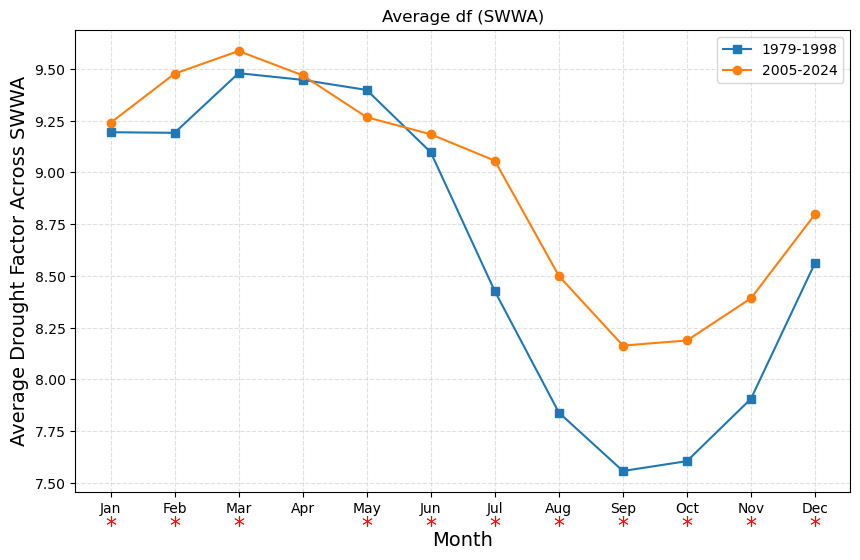

In [32]:
# spatial & monthly avg
df_avg_new = df_new.mean(dim=("lat", "lon"))
df_avg_month_new = df_avg_new.groupby("time.month").mean("time")
df_avg_old = df_old.mean(dim=("lat", "lon"))
df_avg_month_old = df_avg_old.groupby("time.month").mean("time")

# Calc stat signficiance (Mann-Whitney U Test)
p_values = []
for m in range(1, 13):
    new_vals = df_new.sel(time=temp_new['time.month'] == m).mean(dim=("lat", "lon")).values # select month
    old_vals = df_old.sel(time=temp_old['time.month'] == m).mean(dim=("lat", "lon")).values
    new_vals = new_vals[~np.isnan(new_vals)]
    old_vals = old_vals[~np.isnan(old_vals)]
    stat, p = stats.mannwhitneyu(old_vals, new_vals, alternative='two-sided') # apply stat test
    p_values.append(p)

# figure set-up
plt.figure(figsize=(10,6))
df_avg_month_old.plot(marker="s", label = "1979-1998")
df_avg_month_new.plot(marker="o", label = "2005-2024")
plt.grid(True, which='both', linestyle='--', color='lightgrey', alpha=0.7) # grid lines

# replace ticks with month names
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in df_avg_month_old["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[m] for m in df_avg_month_new["month"].values])
plt.xticks(ticks=range(1,13), labels=[calendar.month_abbr[(i+0)%12+1] for i in range(12)])

# add asterisks for stat sig months
ymin, ymax = plt.ylim()
asterisk_y = ymin - (ymax - ymin) * 0.05  # place slightly below the axis, adjust if needed
for i, p in enumerate(p_values):
    if p < 0.05:
        plt.text(i+1, asterisk_y, '*', ha='center', va='top', fontsize=16, color='red')

# produce figure
plt.title("Average df (SWWA)")
plt.xlabel("Month", fontsize = 14, labelpad = 11) # labelpad lowers title
plt.ylabel("Average Drought Factor Across SWWA", fontsize = 14)
plt.legend()

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/df_timeseries.png", dpi=600)
plt.show()

In [36]:
# finding largest % increase
# (new-old) / old x 100
percent_change = ((df_avg_month_old - df_avg_month_new) / df_avg_month_new) * 100

# identify month with largest
max_change = percent_change.min().item()  # most negative value
max_month_num = percent_change['month'][percent_change.argmin().item()].item()
max_month_name = calendar.month_abbr[max_month_num]

print(f"Largest % increase: {min_change:.2f}% in {min_month_name}")

Largest % increase: -7.77% in Aug


# Frequency Distribution Histograms

### FFDI

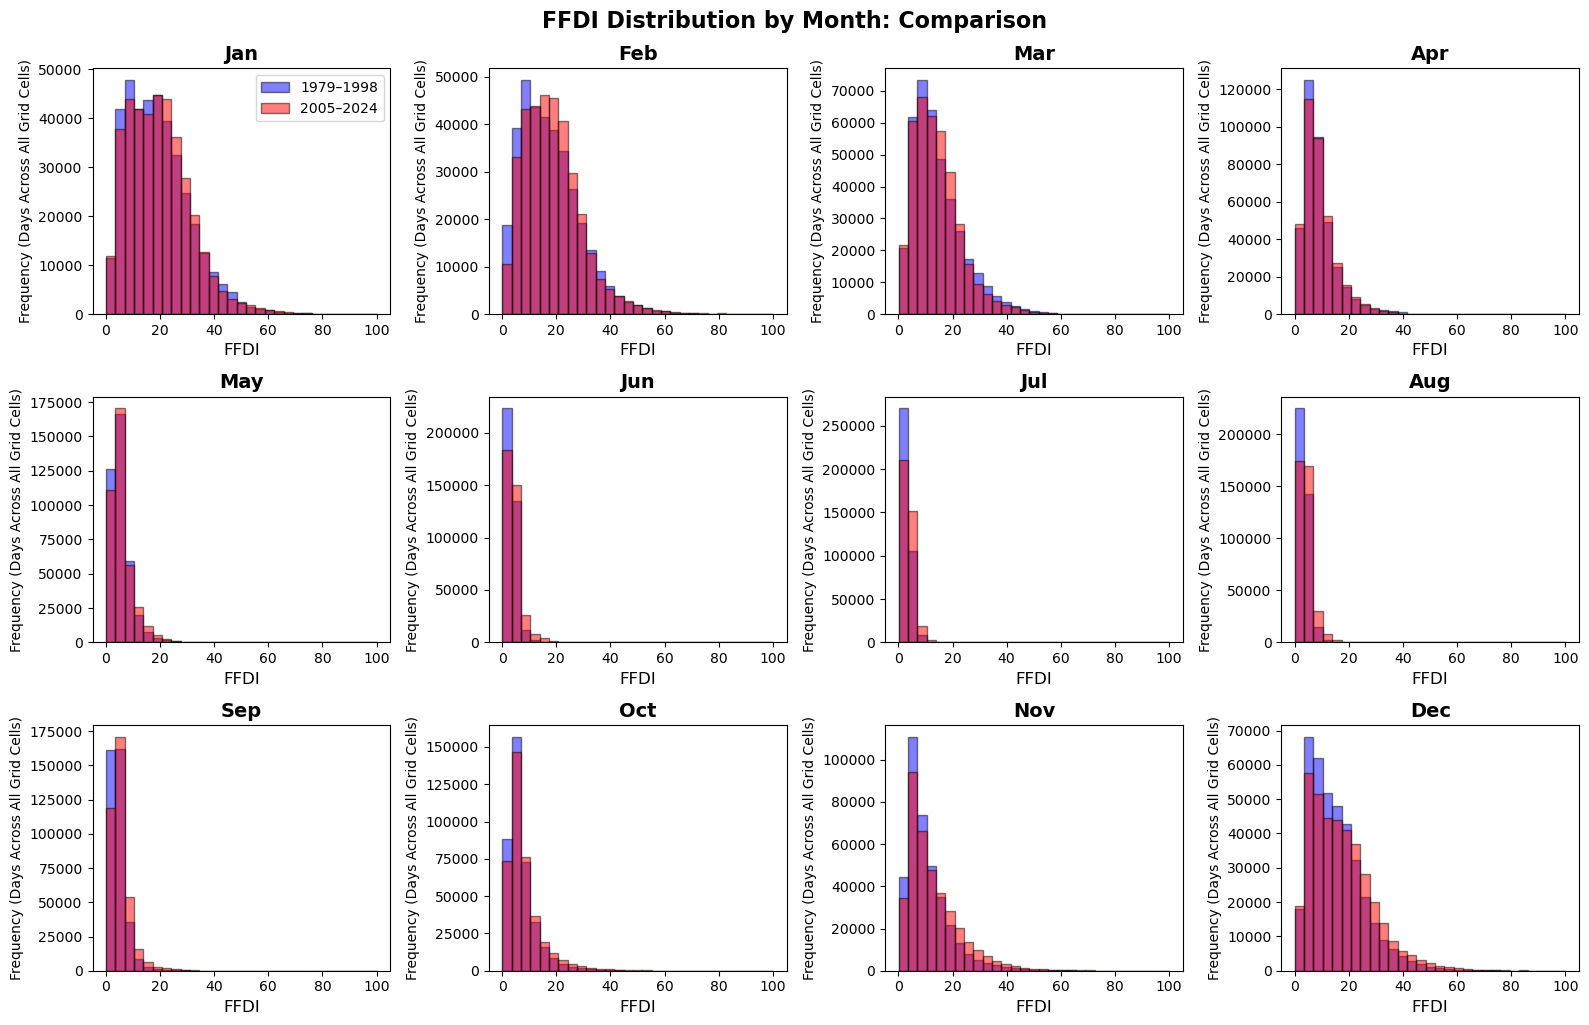

In [48]:
# flatten data to get min and max
all_data = np.concatenate([
    ffdi_var.values.flatten(),
    ffdi_var_old.values.flatten()
])

# ignore nans
min_val = np.nanmin(all_data)
max_val = np.nanmax(all_data)

# shared bins so it aligns
bins = np.linspace(min_val, max_val, 30)

# group by month
ffdi_histogram_old = ffdi_var_old.groupby("time.month")
ffdi_histogram_new = ffdi_var.groupby("time.month")

# set-up figure
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# create histogram
for i in range(1, 13):
    month_data_old = ffdi_histogram_old[i].values.flatten() # flattening into an cumulation
    month_data_new = ffdi_histogram_new[i].values.flatten()
    
    axes[i-1].hist(month_data_old, bins=bins, color='blue', alpha=0.5, edgecolor='black', label='1979–1998')
    axes[i-1].hist(month_data_new, bins=bins, color='red', alpha=0.5, edgecolor='black', label='2005–2024')
    
    axes[i-1].set_title(f"{calendar.month_abbr[i]}", fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel("FFDI", fontsize = 12)
    axes[i-1].set_ylabel("Frequency (Days Across All Grid Cells)")
    
    if i == 1:
        axes[i-1].legend()

plt.tight_layout()
plt.suptitle("FFDI Distribution by Month: Comparison", fontsize=16, fontweight='bold', y=1.02)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/ffdi_histogram.png", dpi=600)
plt.show()

### Windspeed

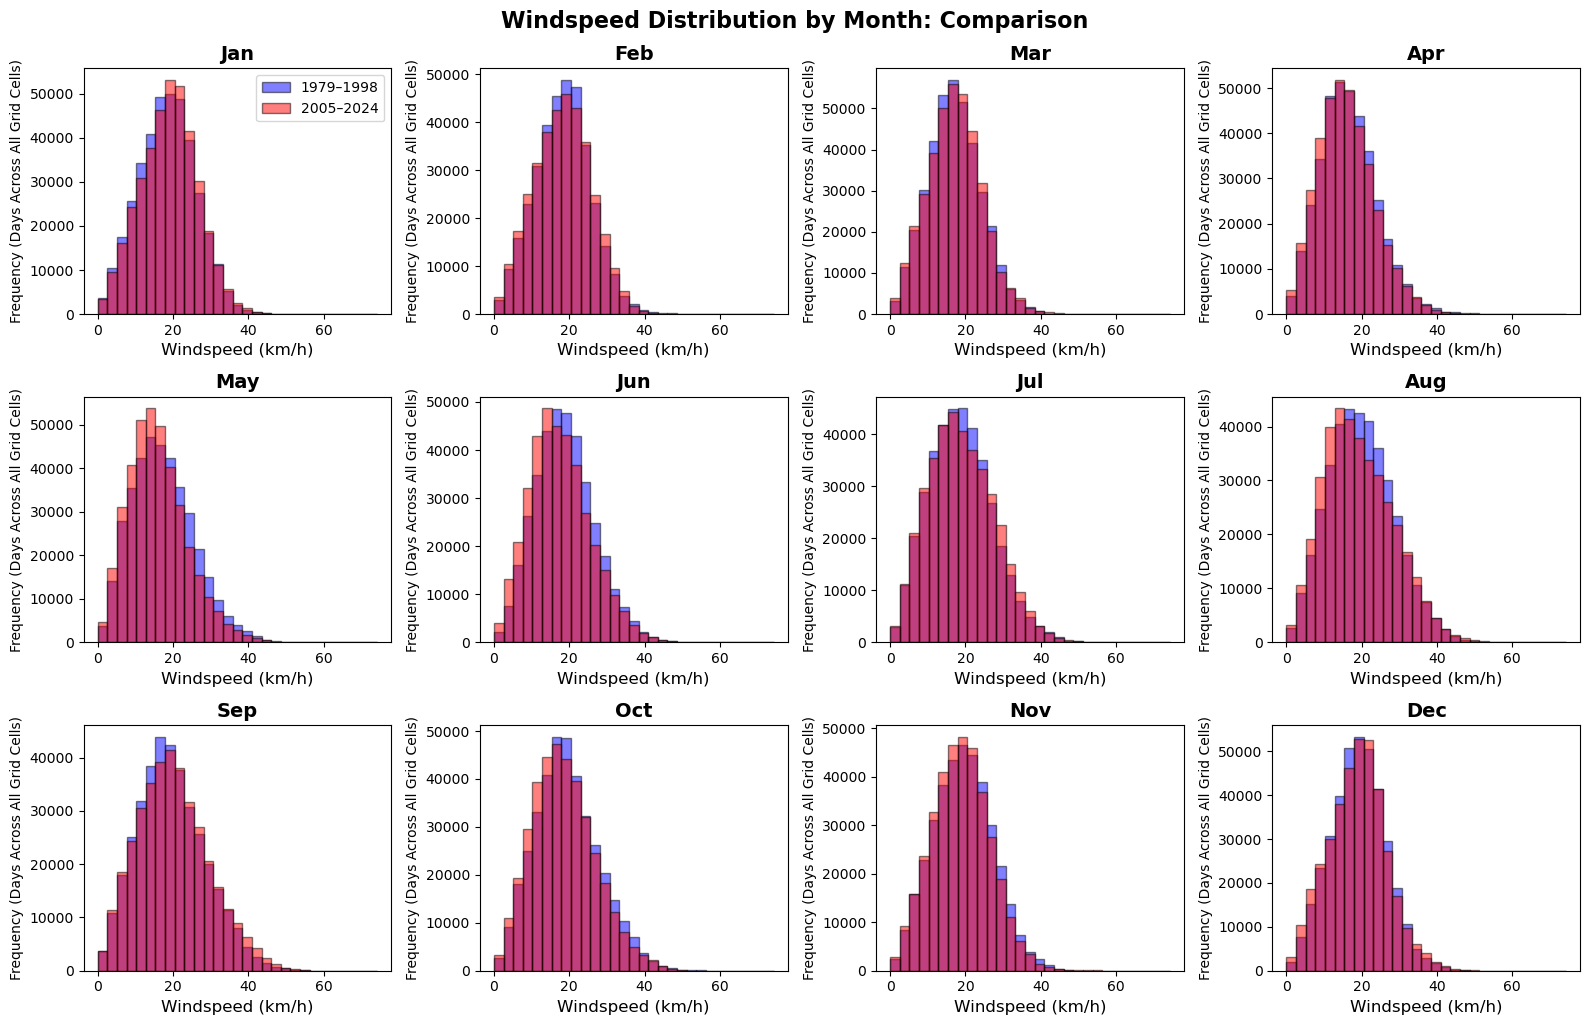

In [49]:
# flatten data to get min and max
all_data = np.concatenate([
    wind_new.values.flatten(),
    wind_old.values.flatten()
])

# ignore nans
min_val = np.nanmin(all_data)
max_val = np.nanmax(all_data)

# shared bins so it aligns
bins = np.linspace(min_val, max_val, 30)

# group by month
wind_histogram_old = wind_old.groupby("time.month")
wind_histogram_new = wind_new.groupby("time.month")

# set-up figure
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# create histogram
for i in range(1, 13):
    month_data_old = wind_histogram_old[i].values.flatten() # flattening into an cumulation
    month_data_new = wind_histogram_new[i].values.flatten()
    
    axes[i-1].hist(month_data_old, bins=bins, color='blue', alpha=0.5, edgecolor='black', label='1979–1998')
    axes[i-1].hist(month_data_new, bins=bins, color='red', alpha=0.5, edgecolor='black', label='2005–2024')
    
    axes[i-1].set_title(f"{calendar.month_abbr[i]}", fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel("Windspeed (km/h)", fontsize = 12)
    axes[i-1].set_ylabel("Frequency (Days Across All Grid Cells)")
    
    if i == 1:
        axes[i-1].legend()

plt.tight_layout()
plt.suptitle("Windspeed Distribution by Month: Comparison", fontsize=16, fontweight='bold', y=1.02)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/wind_histogram.png", dpi=600)
plt.show()

### RH

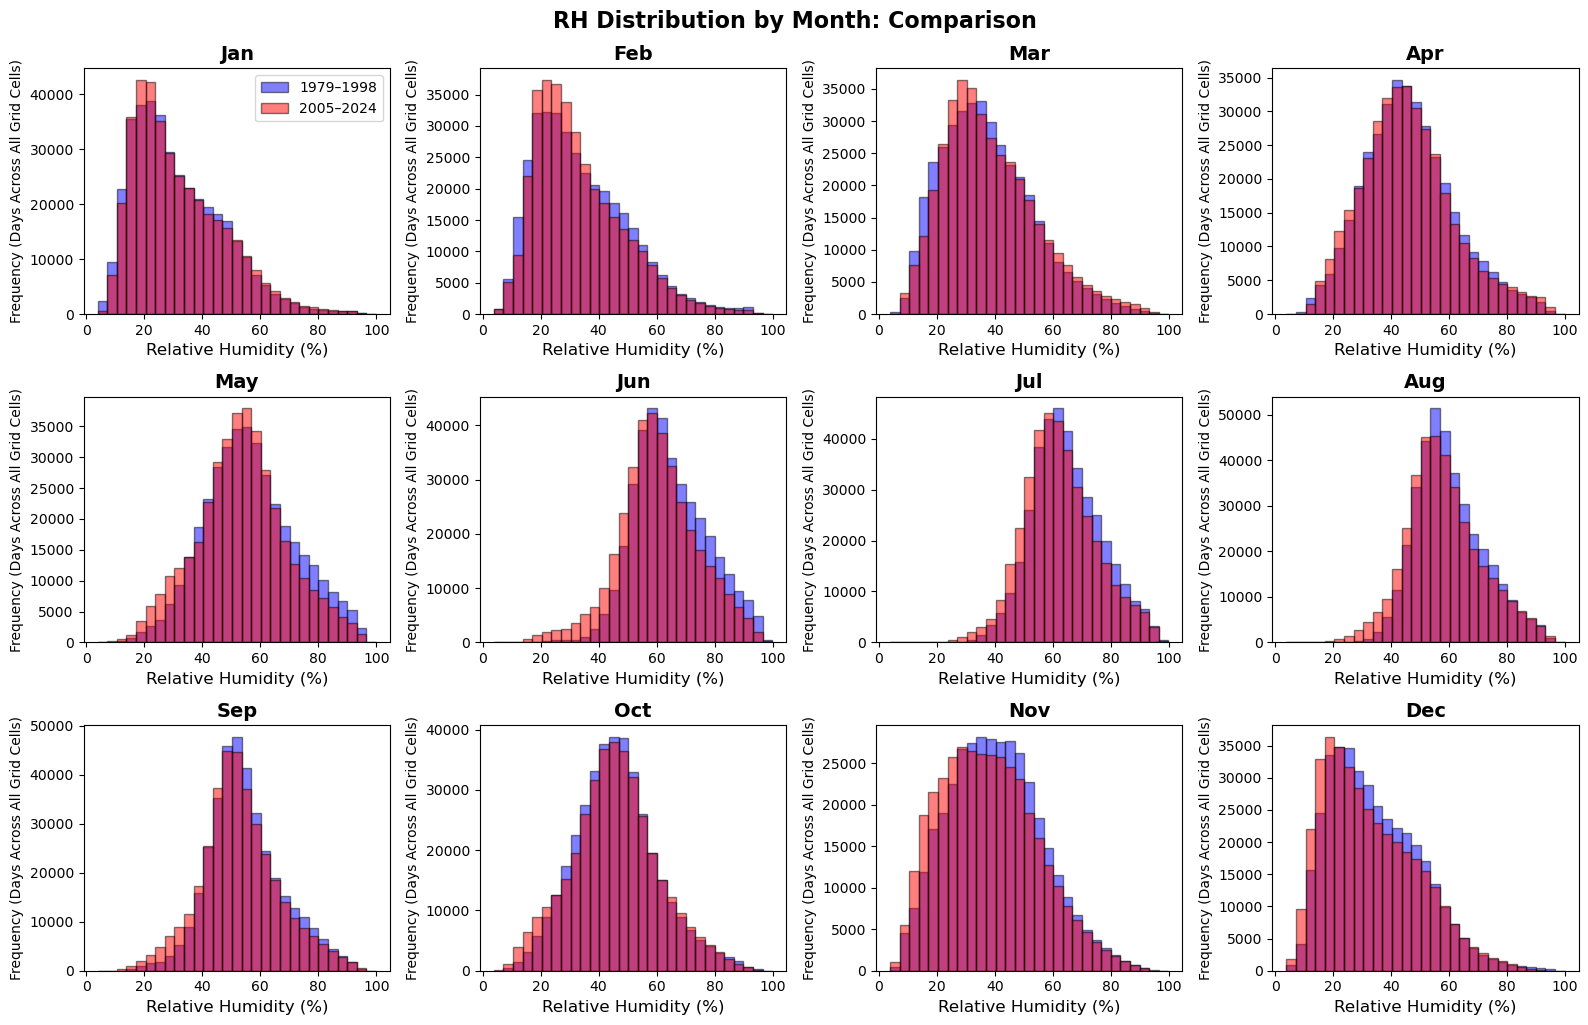

In [50]:
# flatten data to get min and max
all_data = np.concatenate([
    rh_new.values.flatten(),
    rh_old.values.flatten()
])

# ignore nans
min_val = np.nanmin(all_data)
max_val = np.nanmax(all_data)

# shared bins so it aligns
bins = np.linspace(min_val, max_val, 30)

# group by month
rh_histogram_old = rh_old.groupby("time.month")
rh_histogram_new = rh_new.groupby("time.month")

# set-up figure
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# create histogram
for i in range(1, 13):
    month_data_old = rh_histogram_old[i].values.flatten() # flattening into an cumulation
    month_data_new = rh_histogram_new[i].values.flatten()
    
    axes[i-1].hist(month_data_old, bins=bins, color='blue', alpha=0.5, edgecolor='black', label='1979–1998')
    axes[i-1].hist(month_data_new, bins=bins, color='red', alpha=0.5, edgecolor='black', label='2005–2024')
    
    axes[i-1].set_title(f"{calendar.month_abbr[i]}", fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel("Relative Humidity (%)", fontsize = 12)
    axes[i-1].set_ylabel("Frequency (Days Across All Grid Cells)")
    
    if i == 1:
        axes[i-1].legend()

plt.tight_layout()
plt.suptitle("RH Distribution by Month: Comparison", fontsize=16, fontweight='bold', y=1.02)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/rh_histogram.png", dpi=600)
plt.show()

In [54]:
# calc median rh for jan & feb
months_to_check = [1, 2]  # January, February

for m in months_to_check:
    # extract all RH values per month & flatten 
    new_vals = rh_new.sel(time=rh_new['time.month'] == m).values.flatten()
    old_vals = rh_old.sel(time=rh_old['time.month'] == m).values.flatten()
    
    # drop NaNs
    new_vals = new_vals[~np.isnan(new_vals)]
    old_vals = old_vals[~np.isnan(old_vals)]
    
    # calculate medians
    median_new = np.median(new_vals)
    median_old = np.median(old_vals)
    
    # percent change around the median
    percent_change = ((median_new - median_old) / median_old) * 100
    
    print(f"{calendar.month_name[m]}:")
    print(f"  Median (1979–1998): {median_old:.2f}%")
    print(f"  Median (2005–2024): {median_new:.2f}%")
    print(f"  Percent change: {percent_change:.2f}%\n")


January:
  Median (1979–1998): 28.05%
  Median (2005–2024): 28.01%
  Percent change: -0.12%

February:
  Median (1979–1998): 30.81%
  Median (2005–2024): 29.82%
  Percent change: -3.21%



### Temperature

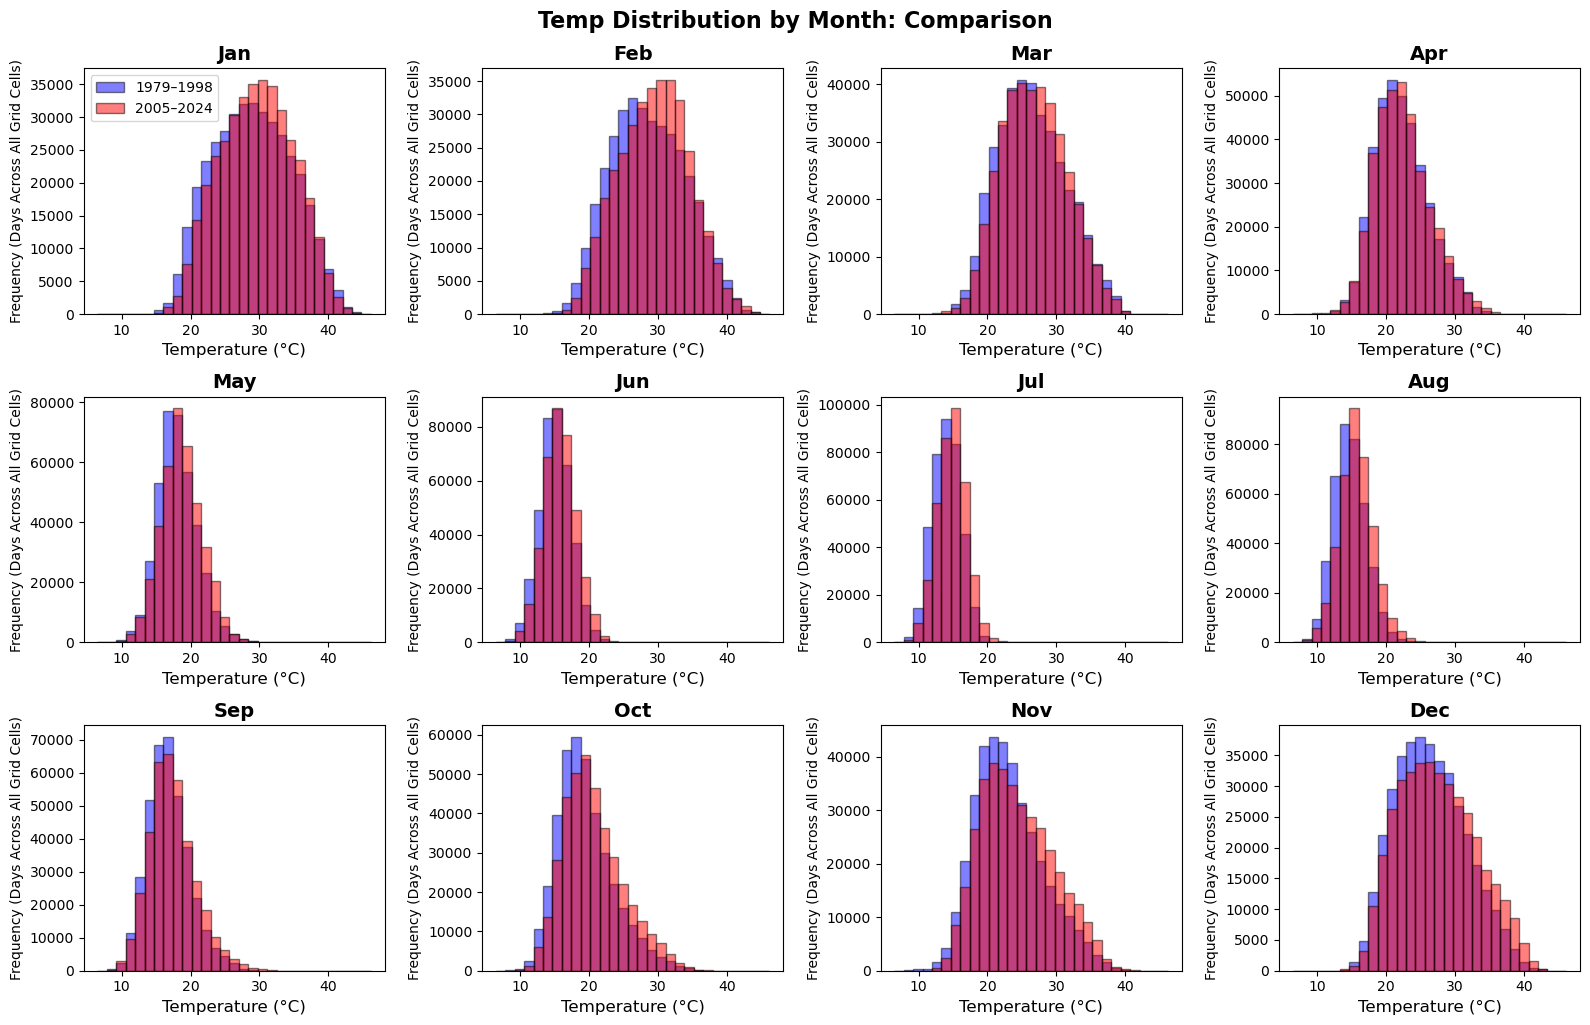

In [55]:
# flatten data to get min and max
all_data = np.concatenate([
    temp_new.values.flatten(),
    temp_old.values.flatten()
])

# ignore nans
min_val = np.nanmin(all_data)
max_val = np.nanmax(all_data)

# shared bins so it aligns
bins = np.linspace(min_val, max_val, 30)

# group by month
temp_histogram_old = temp_old.groupby("time.month")
temp_histogram_new = temp_new.groupby("time.month")

# set-up figure
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# create histogram
for i in range(1, 13):
    month_data_old = temp_histogram_old[i].values.flatten() # flattening into an cumulation
    month_data_new = temp_histogram_new[i].values.flatten()
    
    axes[i-1].hist(month_data_old, bins=bins, color='blue', alpha=0.5, edgecolor='black', label='1979–1998')
    axes[i-1].hist(month_data_new, bins=bins, color='red', alpha=0.5, edgecolor='black', label='2005–2024')
    
    axes[i-1].set_title(f"{calendar.month_abbr[i]}", fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel("Temperature (°C)", fontsize = 12)
    axes[i-1].set_ylabel("Frequency (Days Across All Grid Cells)")
    
    if i == 1:
        axes[i-1].legend()

plt.tight_layout()
plt.suptitle("Temp Distribution by Month: Comparison", fontsize=16, fontweight='bold', y=1.02)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/temp_histogram.png", dpi=600)
plt.show()

In [56]:
# months for June, July, August
months_jja = [6, 7, 8]

# extract and flatten data for JJA in both periods
temp_jja_old = temp_old.sel(time=temp_old['time.month'].isin(months_jja)).values.flatten()
temp_jja_new = temp_new.sel(time=temp_new['time.month'].isin(months_jja)).values.flatten()

# ignore NaNs
temp_jja_old = temp_jja_old[~np.isnan(temp_jja_old)]
temp_jja_new = temp_jja_new[~np.isnan(temp_jja_new)]

# find min, max, and range
min_old, max_old = temp_jja_old.min(), temp_jja_old.max()
min_new, max_new = temp_jja_new.min(), temp_jja_new.max()

range_old = max_old - min_old
range_new = max_new - min_new

print(f"1979–1998 JJA: min = {min_old:.2f}°C, max = {max_old:.2f}°C, range = {range_old:.2f}°C")
print(f"2005–2024 JJA: min = {min_new:.2f}°C, max = {max_new:.2f}°C, range = {range_new:.2f}°C")


1979–1998 JJA: min = 6.48°C, max = 26.83°C, range = 20.36°C
2005–2024 JJA: min = 7.65°C, max = 29.88°C, range = 22.23°C


### Drought Factor (DF)

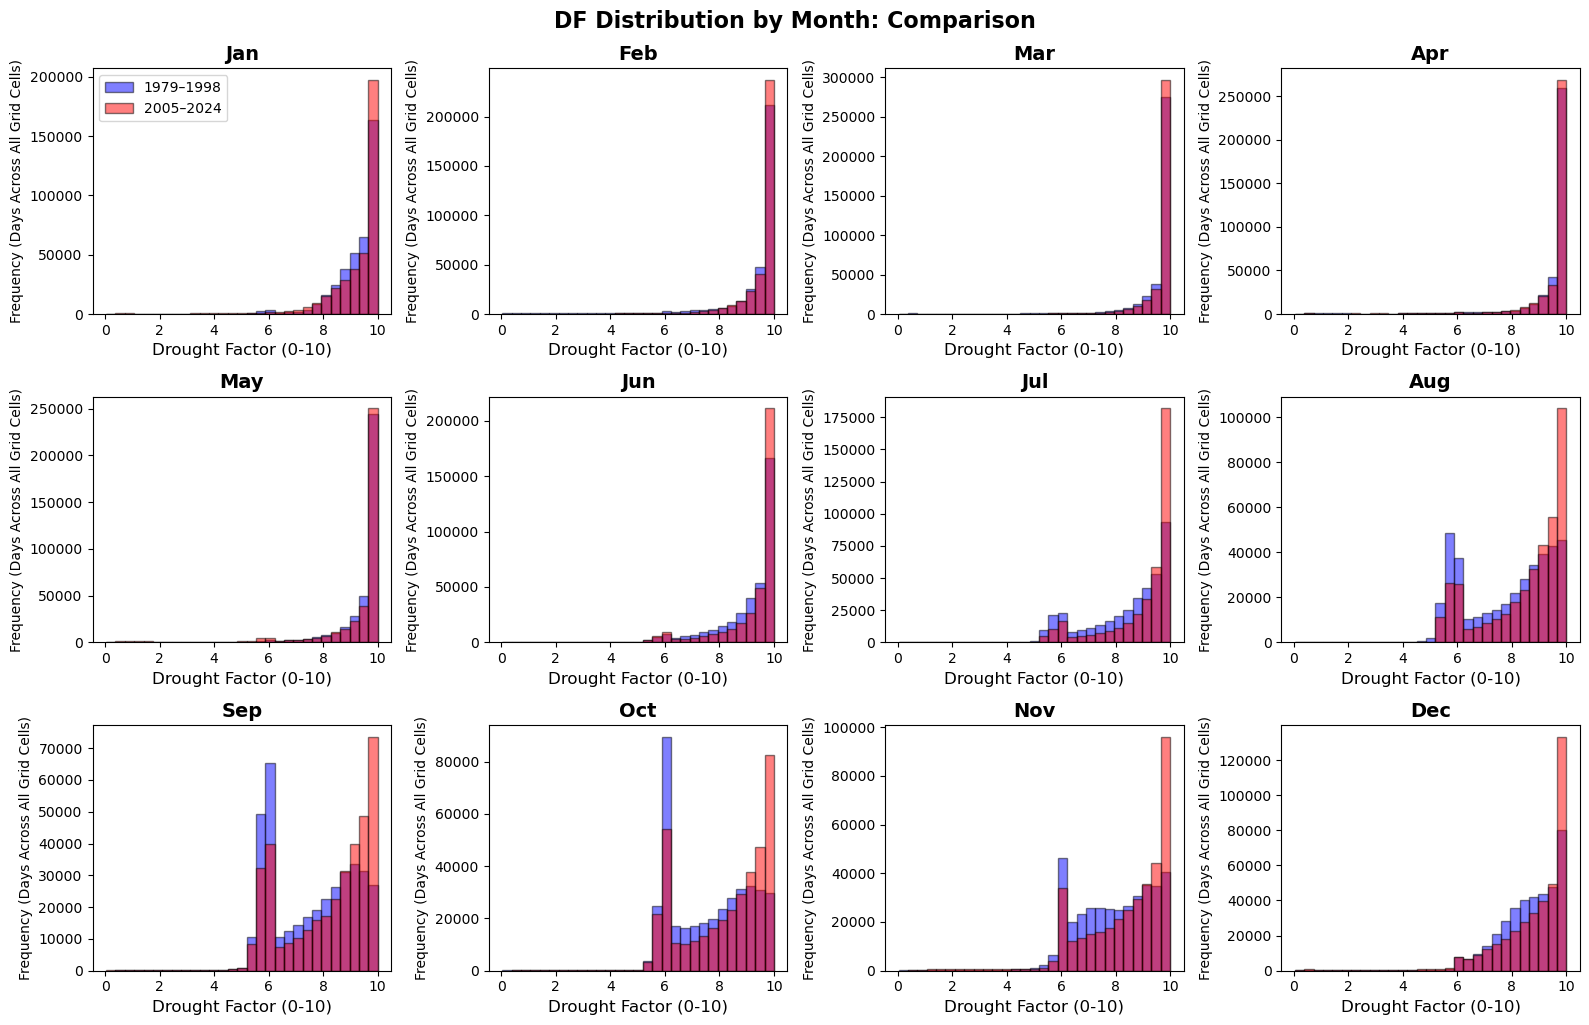

In [62]:
# flatten data to get min and max
all_data = np.concatenate([
    df_new.values.flatten(),
    df_old.values.flatten()
])

# ignore nans
min_val = np.nanmin(all_data)
max_val = np.nanmax(all_data)

# shared bins so it aligns
bins = np.linspace(min_val, max_val, 30)

# group by month
df_histogram_old = df_old.groupby("time.month")
df_histogram_new = df_new.groupby("time.month")

# set-up figure
fig, axes = plt.subplots(3, 4, figsize=(16, 10))
axes = axes.flatten()

# create histogram
for i in range(1, 13):
    month_data_old = df_histogram_old[i].values.flatten() # flattening into an cumulation
    month_data_new = df_histogram_new[i].values.flatten()
    
    axes[i-1].hist(month_data_old, bins=bins, color='blue', alpha=0.5, edgecolor='black', label='1979–1998')
    axes[i-1].hist(month_data_new, bins=bins, color='red', alpha=0.5, edgecolor='black', label='2005–2024')
    
    axes[i-1].set_title(f"{calendar.month_abbr[i]}", fontsize=14, fontweight='bold')
    axes[i-1].set_xlabel("Drought Factor (0-10)", fontsize = 12)
    axes[i-1].set_ylabel("Frequency (Days Across All Grid Cells)")
    
    if i == 1:
        axes[i-1].legend()

plt.tight_layout()
plt.suptitle("DF Distribution by Month: Comparison", fontsize=16, fontweight='bold', y=1.02)

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/df_histogram.png", dpi=600)
plt.show()

# Median differences (spatial)

### Define MW U test

In [72]:
 # --- Define Mann–Whitney U function ---
def mw_func(a, b):
    """Return p-value of Mann–Whitney U test, ignoring NaNs."""
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if len(a) == 0 or len(b) == 0:
        return np.nan
    return mannwhitneyu(a, b, alternative="two-sided").pvalue

### Temperature

/jobfs/153166189.gadi-pbs/ipykernel_3590674/1414191529.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


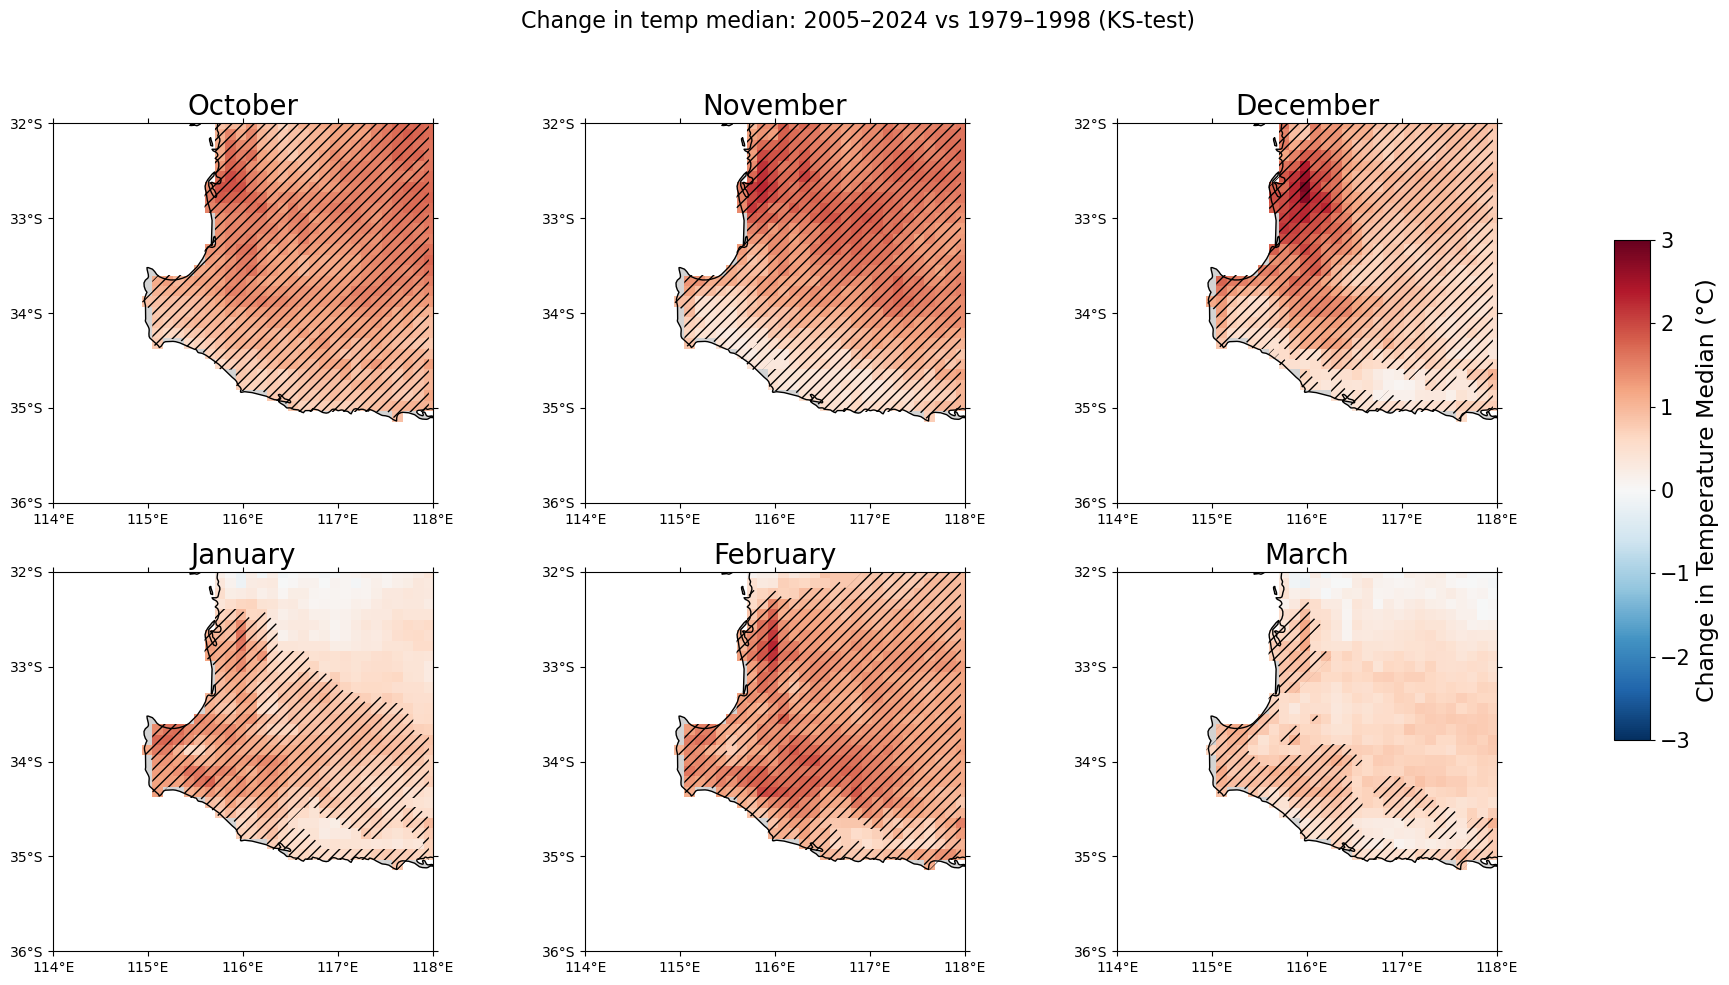

In [82]:
# only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select month
    temp_m1 = temp_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=temp_old['time'].dt.month == m)
    temp_m2 = temp_new.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=temp_new['time'].dt.month == m)

    # calc median & diff between median of the two time periods
    med1 = temp_m1.median(dim="time")
    med2 = temp_m2.median(dim="time")
    diff = med2 - med1

    # apply stat test to data 
    pvals = xr.apply_ufunc(
        mw_func, # call the stat test (MW)
        temp_m1, # old temp
        temp_m2, # new temp
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-3,
        vmax=3
    )
    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Adding lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for significant grid cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20)

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in Temperature Median (°C)")

plt.suptitle("Change in temp median: 2005–2024 vs 1979–1998 (KS-test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/temp_map.png", dpi=600)
plt.show()

In [83]:
# track maximum increase
max_increase = -np.inf
max_month = None

for i, m in enumerate(months):
    temp_m1 = temp_old.sel(time=temp_old['time'].dt.month == m)
    temp_m2 = temp_new.sel(time=temp_new['time'].dt.month == m)

    # median
    med1 = temp_m1.median(dim="time")
    med2 = temp_m2.median(dim="time")
    diff = med2 - med1

    # find max increase in this month
    month_max = diff.max().values  # max value in the diff array
    print(f"{calendar.month_name[m]}: max median increase = {month_max:.2f} °C")

    # check if this is the largest overall
    if month_max > max_increase:
        max_increase = month_max
        max_month = m

print(f"\nLargest increase in median temperature: {max_increase:.2f} °C in {calendar.month_name[max_month]}")


October: max median increase = 1.95 °C
November: max median increase = 2.27 °C
December: max median increase = 2.81 °C
January: max median increase = 1.75 °C
February: max median increase = 2.28 °C
March: max median increase = 1.16 °C

Largest increase in median temperature: 2.81 °C in December


### Windspeed

/jobfs/153166189.gadi-pbs/ipykernel_3590674/3335397178.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


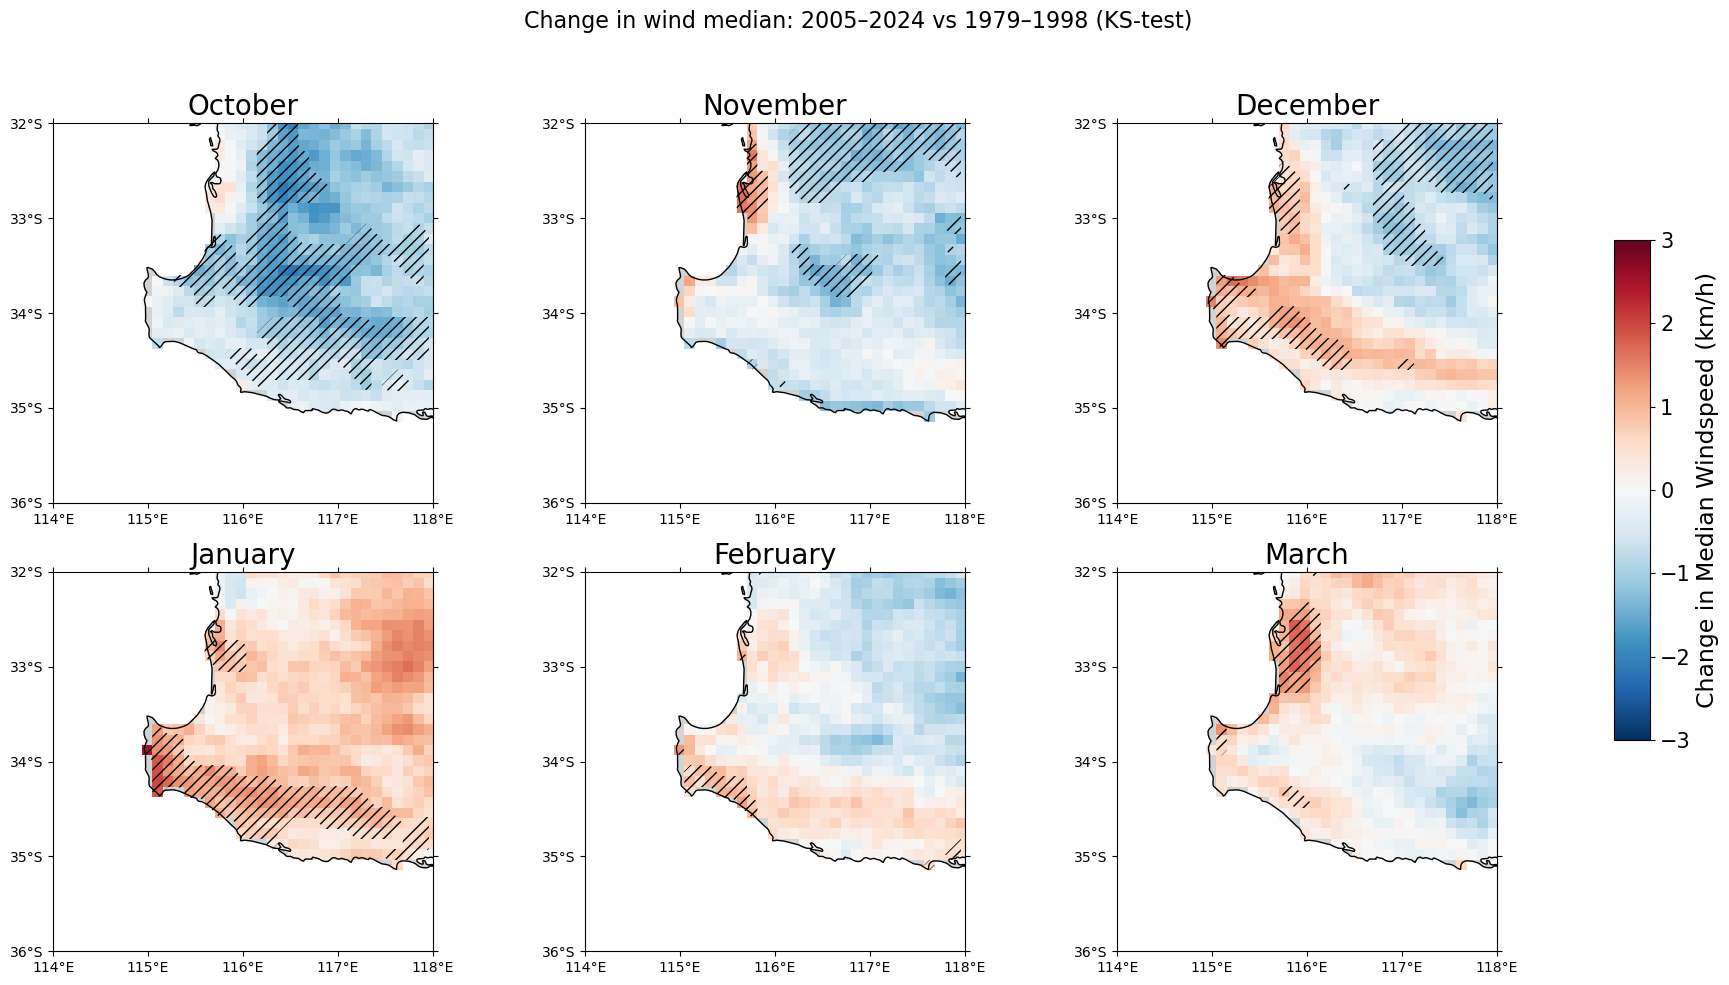

In [84]:
# only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select month
    wind_m1 = wind_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=wind_old['time'].dt.month == m)
    wind_m2 = wind_new.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=wind_new['time'].dt.month == m)

    # calc median & diff between median of the two time periods
    med1 = wind_m1.median(dim="time")
    med2 = wind_m2.median(dim="time")
    diff = med2 - med1

    # apply stat test to data 
    pvals = xr.apply_ufunc(
        mw_func, # call the stat test (MW)
        wind_m1, # old wind
        wind_m2, # new wind
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-3,
        vmax=3
    )
    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Adding lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for significant grid cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20)

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in Median Windspeed (km/h)")

plt.suptitle("Change in wind median: 2005–2024 vs 1979–1998 (KS-test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/wind_map.png", dpi=600)
plt.show()

### RH

/jobfs/153166189.gadi-pbs/ipykernel_3590674/1110315276.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


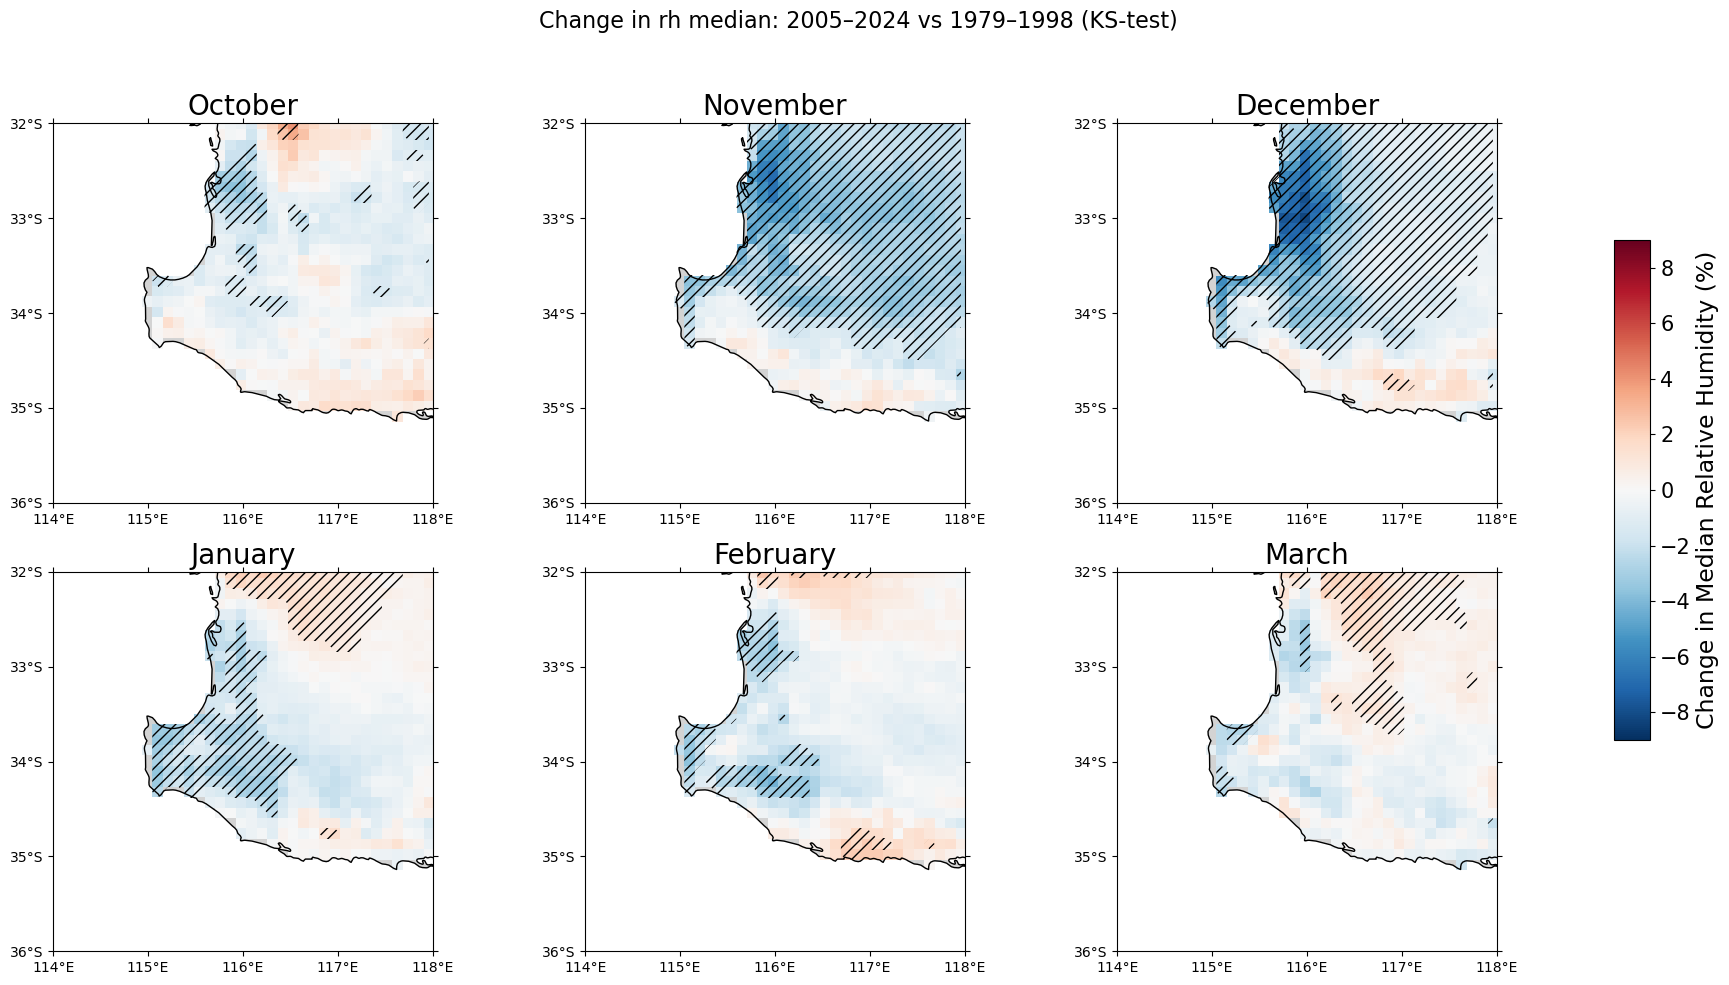

In [85]:
# only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select month
    rh_m1 = rh_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=rh_old['time'].dt.month == m)
    rh_m2 = rh_new.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=rh_new['time'].dt.month == m)

    # calc median & diff between median of the two time periods
    med1 = rh_m1.median(dim="time")
    med2 = rh_m2.median(dim="time")
    diff = med2 - med1

    # apply stat test to data 
    pvals = xr.apply_ufunc(
        mw_func, # call the stat test (MW)
        rh_m1, # old rh
        rh_m2, # new rh
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-9,
        vmax=9
    )
    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Adding lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for significant grid cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20)

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in Median Relative Humidity (%)")

plt.suptitle("Change in rh median: 2005–2024 vs 1979–1998 (KS-test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/rh_map.png", dpi=600)
plt.show()

### DF

/jobfs/153166189.gadi-pbs/ipykernel_3590674/2007530157.py:77: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


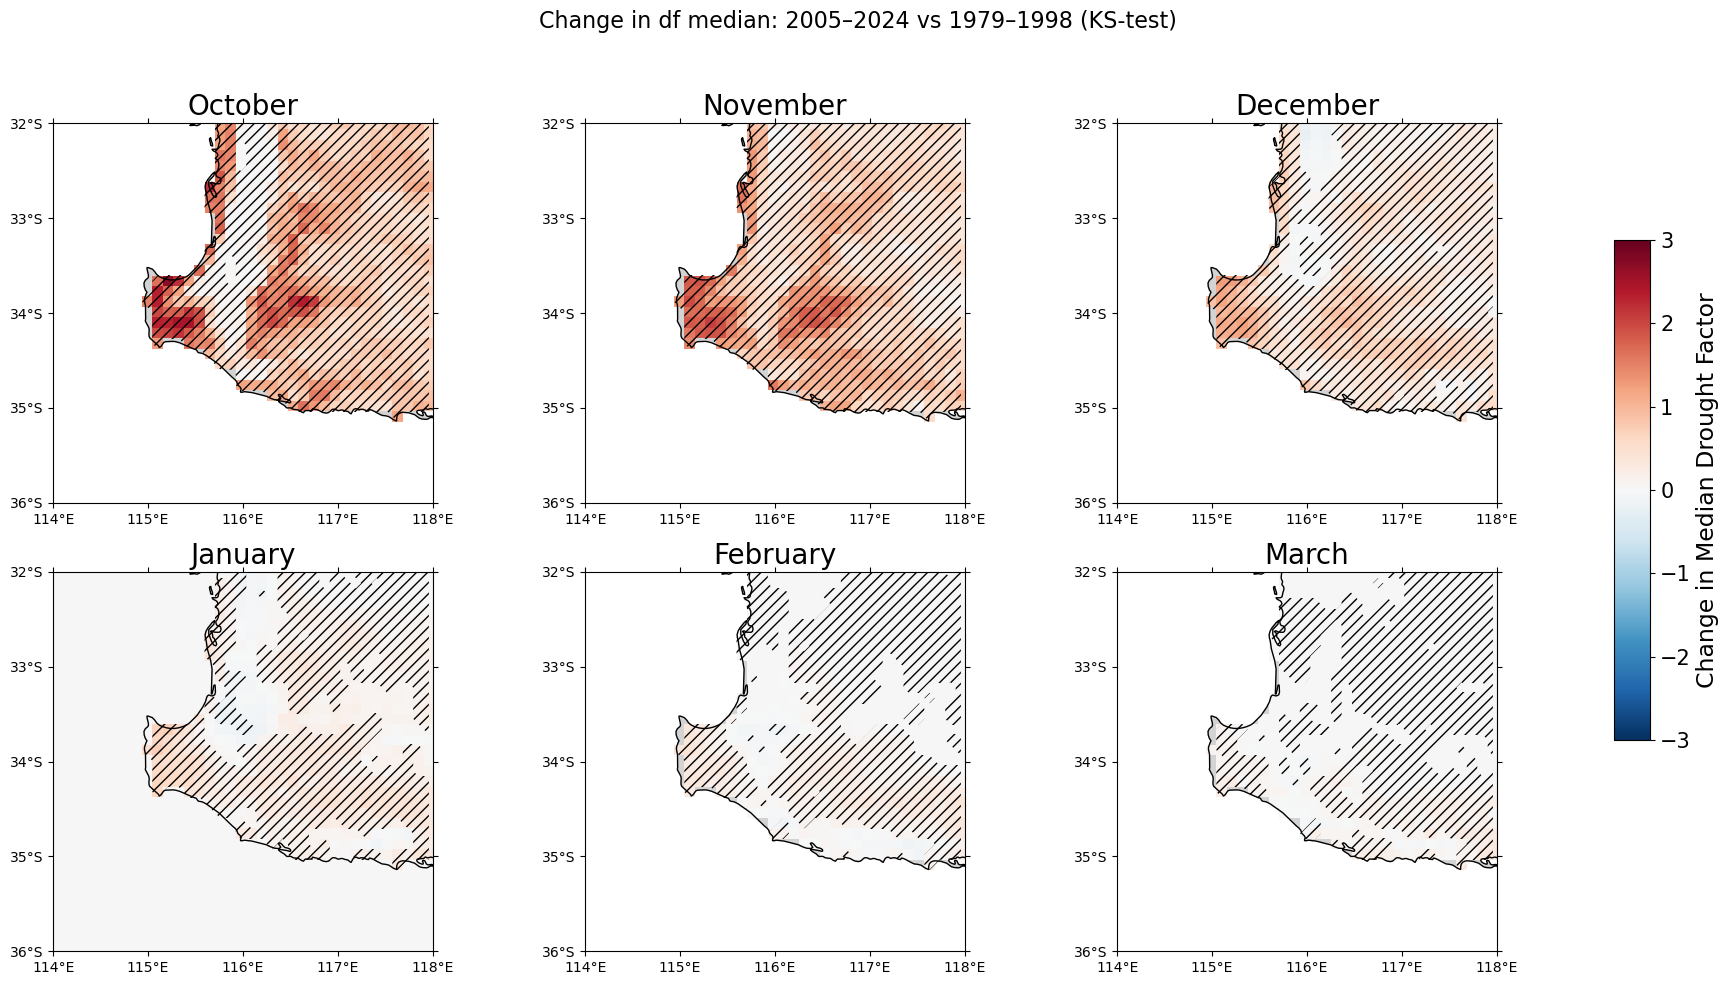

In [88]:
# only months Oct–Mar (10,11,12,1,2,3)
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

for i, m in enumerate(months):
    # select month
    df_m1 = df_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=df_old['time'].dt.month == m)
    df_m2 = df_new.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=df_new['time'].dt.month == m)

    # calc median & diff between median of the two time periods
    med1 = df_m1.median(dim="time")
    med2 = df_m2.median(dim="time")
    diff = med2 - med1

    # apply stat test to data 
    pvals = xr.apply_ufunc(
        mw_func, # call the stat test (MW)
        df_m1, # old rh
        df_m2, # new rh
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # plot
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap="RdBu_r",
        add_colorbar=False,
        vmin=-3,
        vmax=3
    )
    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # Adding lat & lon to map 
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA extent
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree()) #explicitly include both edges of domain
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)
    axes[i].tick_params( # draw ticks on all sides
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hacthing for significant grid cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize = 20)

cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5]) # shared colourbar
cbar_ax.yaxis.label.set_size(17)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in Median Drought Factor")

plt.suptitle("Change in df median: 2005–2024 vs 1979–1998 (KS-test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/df_map.png", dpi=600)
plt.show()

### FFDI: 2 prop z test

/jobfs/153166189.gadi-pbs/ipykernel_3590674/3555435797.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


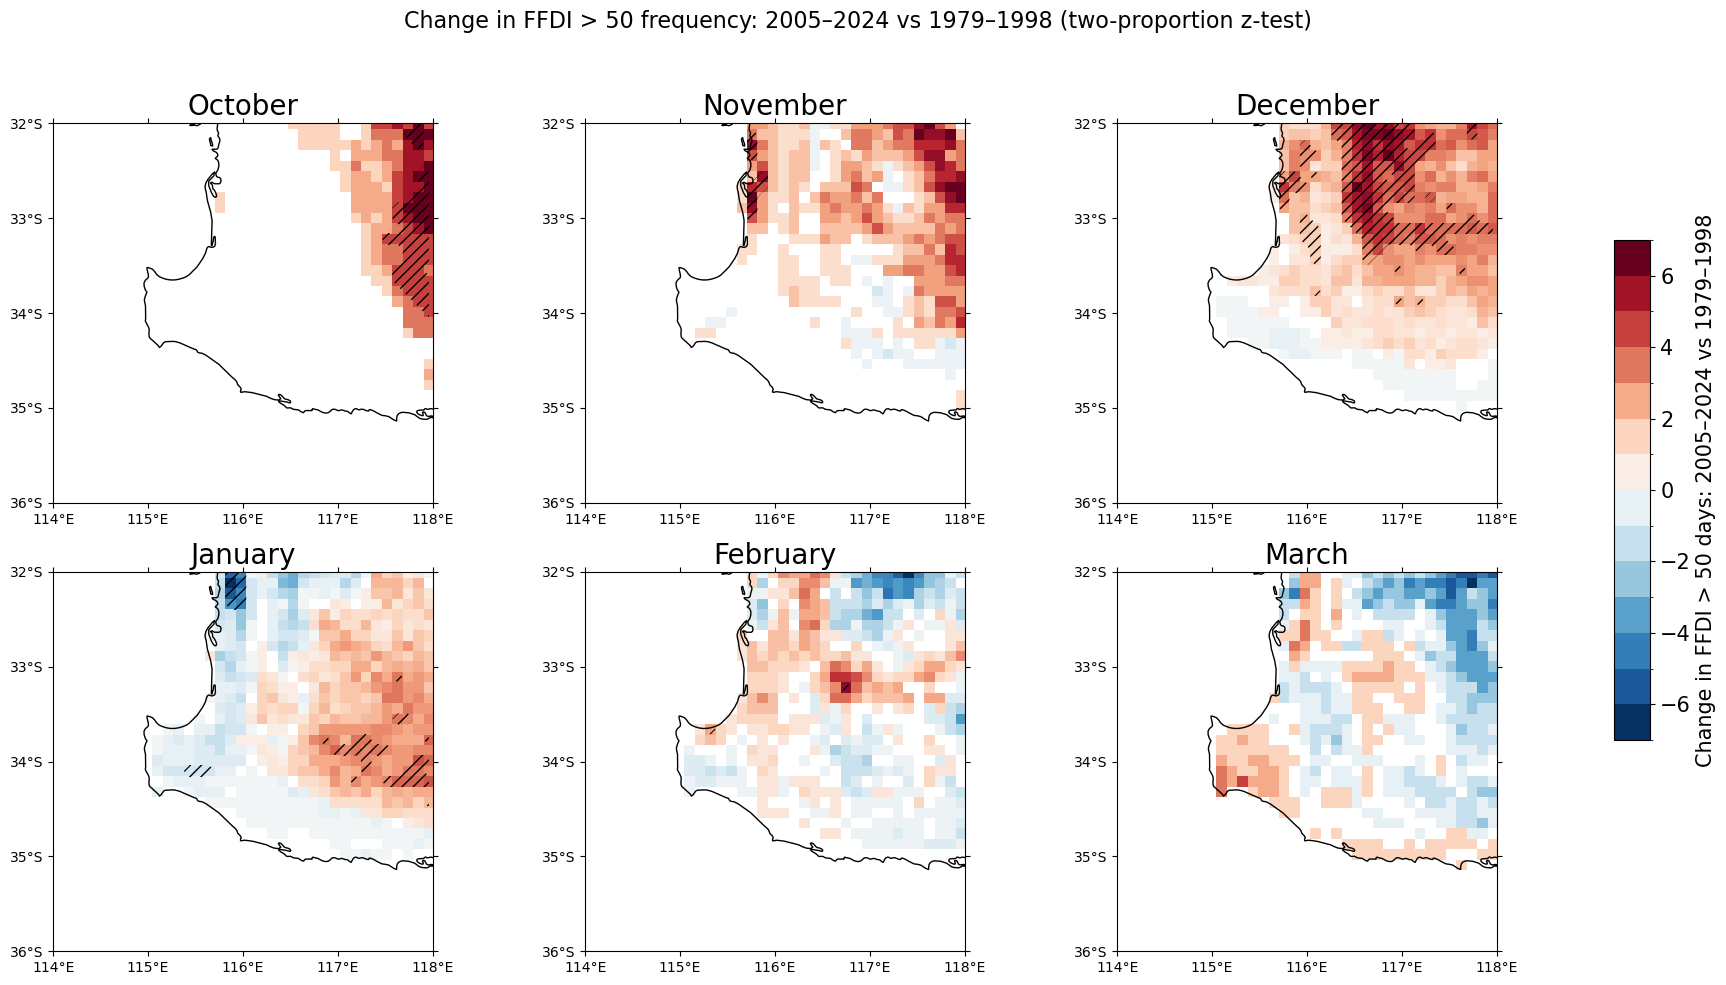

In [103]:
# define stat sig test: two-proportion z-test
def prop_test(a, b):
    # drop NaNs
    a = a[~np.isnan(a)]
    b = b[~np.isnan(b)]
    if (len(a) == 0) or (len(b) == 0):
        return np.nan
    
    # counts of exceedances
    count = [np.sum(a == 1), np.sum(b == 1)]
    nobs = [len(a), len(b)]
    
    # if both have zero exceedances, skip
    if count[0] == 0 and count[1] == 0:
        return np.nan
    
    stat, p = proportions_ztest(count, nobs)
    return p

# Only months Oct–Mar (10,11,12,1,2,3), as before
months = [10, 11, 12, 1, 2, 3]

fig, axes = plt.subplots(2, 3, figsize=(18, 10), subplot_kw={'projection': ccrs.PlateCarree()})
axes = axes.flatten()

# only FFDI > 50 values (extreme)
for i, m in enumerate(months):
    ffdi_m1 = ffdi_var_old.sel(time=slice("1979-01-01", "1998-12-31")).sel(time=ffdi_var_old['time'].dt.month == m)
    ffdi_m2 = ffdi_var.sel(time=slice("2005-01-01", "2024-12-31")).sel(time=ffdi_var['time'].dt.month == m)

    ffdi_m1_50 = (ffdi_m1 > 50).astype(float)
    ffdi_m2_50 = (ffdi_m2 > 50).astype(float)

    freq1 = ffdi_m1_50.sum(dim="time")
    freq2 = ffdi_m2_50.sum(dim="time")
    diff = freq2 - freq1

    # apply stat sig test
    pvals = xr.apply_ufunc(
        prop_test,
        ffdi_m1_50,
        ffdi_m2_50,
        input_core_dims=[["time"], ["time"]],
        vectorize=True,
        dask="parallelized",
        output_dtypes=[float],
        join="override"
    )

    # Define discrete bins (example: integer differences from -max to +max)
    max_diff = int(np.nanmax(np.abs(diff)))  # largest absolute change in frequency
    levels = np.arange(-max_diff, max_diff+1, 1)  # e.g., step=1 day
    # Create a norm for discrete colors
    norm = BoundaryNorm(levels, ncolors=plt.cm.RdBu_r.N, clip=True)
    
    # plot difference map
    im = diff.plot(
        ax=axes[i],
        x='lon', y='lat',
        cmap=plt.cm.RdBu_r,
        norm=norm,
        add_colorbar=False
    )
    im.cmap.set_bad("white")  # make zeros (masked) white
    diff_masked = diff.where(diff != 0)  # mask zeros
    im = diff_masked.plot(ax=axes[i], x='lon', y='lat', cmap=plt.cm.RdBu_r, norm=norm, add_colorbar=False)
    im.cmap.set_bad("white")


    axes[i].add_feature(cfeature.COASTLINE, linewidth=1)
    axes[i].add_feature(cfeature.LAND, facecolor="lightgrey")

    # format lat & lon
    axes[i].set_extent([114, 118, -36, -32], crs=ccrs.PlateCarree()) # set SWWA bounds
    axes[i].set_xlabel("") # no axis labels
    axes[i].set_ylabel("")
    axes[i].set_xticks([114, 115, 116, 117, 118], crs=ccrs.PlateCarree())
    axes[i].set_yticks([-36, -35, -34, -33, -32], crs=ccrs.PlateCarree())

    # formatters
    lon_formatter = cticker.LongitudeFormatter(zero_direction_label=True)
    lat_formatter = cticker.LatitudeFormatter()
    axes[i].xaxis.set_major_formatter(lon_formatter)
    axes[i].yaxis.set_major_formatter(lat_formatter)

    # add ticks on all sides
    axes[i].tick_params(
        bottom=True, top=True,
        left=True, right=True,
        labelbottom=True, labeltop=False,
        labelleft=True, labelright=False
    )

    # hatching for stat sig grid cells
    sig = (pvals < 0.05)
    axes[i].contourf(
        diff['lon'], diff['lat'], sig,
        levels=[0.5, 1],
        colors='none',
        hatches=['///'],
        transform=ccrs.PlateCarree(),
        alpha=0
    )

    axes[i].set_title(pd.to_datetime(f"{m}", format="%m").strftime('%B'), fontsize=20)

# colourbar
cbar_ax = fig.add_axes([0.92, 0.25, 0.02, 0.5])
cbar_ax.yaxis.label.set_size(15)  # fontsize for the colourbar label
cbar_ax.tick_params(labelsize=15)  # fontsize for the numbers on cbar
fig.colorbar(im, cax=cbar_ax, label="Change in FFDI > 50 days: 2005–2024 vs 1979–1998")

plt.suptitle("Change in FFDI > 50 frequency: 2005–2024 vs 1979–1998 (two-proportion z-test)", fontsize=16)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])

plt.savefig("/g/data/ng72/mf9479/k10_transfer/Thesis/FFDI/FINAL_CODE/ffdi_50_map.png", dpi=600)
plt.show()